<a href="https://colab.research.google.com/github/youznn/dl-study/blob/main/FashionMNIST_SOTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fashion MNIST의 SOTA는 Fine-Tuning DARTS임을 확인했다.
해당 논문을 살펴보니

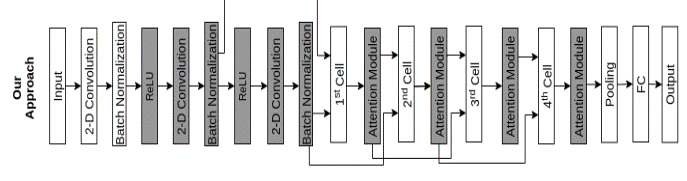

다음과 같은 형태로 구현된다. 중간에 빠져나와서 합쳐지는 부분이 있어서 sequential 모듈을 사용하지 않는다.

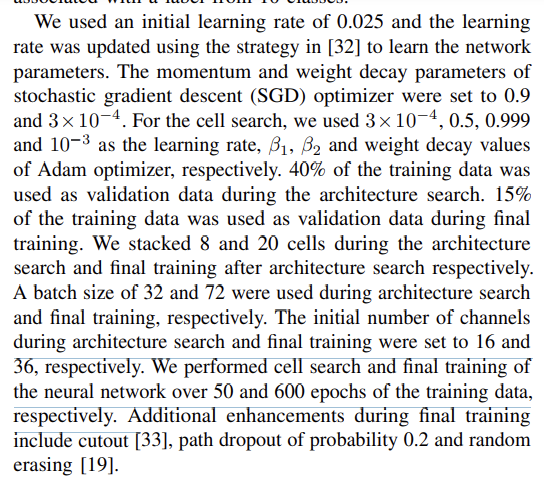

하이퍼 파라미터 관련 부분

Initial learning rate: 0.025

Momentum: 0.9

Weight decay: 3e-4

Adam optimizer learning rate: 3e-4

Adam optimizer beta1: 0.5

Adam optimizer beta2: 0.999

Adam optimizer weight decay: 1e-3

Validation data split during architecture search: 40%

Validation data split during final training: 15%

Architecture search epochs: 50

Final training epochs: 600

Batch size during architecture search: 32

Batch size during final training: 72

Initial number of channels during architecture search: 16

Initial number of channels during final training: 36

로 세팅한다.


In [ ]:
#열심히 쌓아주기
# input - Conv2D - BatchNorm - ReLu
inputs = keras.layers.Input(shape=(28, 28, 1))
conv2d_1 = keras.layers.Conv2D(16, (3, 3), input_shape=(28, 28, 1), padding='same')(inputs)
batchnorm_1 = keras.layers.BatchNormalization()(conv2d_1)
relu_1 = keras.layers.ReLU()(batchnorm_1)

# Conv2D - BatchNorm - ReLu
conv2d_2 = keras.layers.Conv2D(32, (3, 3), padding='same')(relu_1)
batchnorm_2 = keras.layers.BatchNormalization()(conv2d_2)
relu_2 = keras.layers.ReLU()(batchnorm_2)

# Conv2D - BatchNorm
conv2d_3 = keras.layers.Conv2D(32, (3, 3), padding='same')(relu_2)
batchnorm_3 = keras.layers.BatchNormalization()(conv2d_3)

# 2번째 BatchNormalization + 3번째 BatchNormalization (1stcell) - attention module 1
attention_1 = keras.layers.Attention()([batchnorm_2, batchnorm_3])

# 3번째 BatchNormalization + 1번째 Attention 모듈 - attention module 2
attention_2 = keras.layers.Attention()([batchnorm_3, attention_1])

# 1번째 Attention 모듈 + 2번째 Attention 모듈 - attention module 3
attention_3 = keras.layers.Attention()([attention_1, attention_2])

# 2번째 Attention 모듈 + 3번째 Attention 모듈 - attention module 4
attention_4 = keras.layers.Attention()([attention_2, attention_3])

# pooling - (flatten)- FC - output
pooling = keras.layers.MaxPooling2D(pool_size=(2, 2))(attention_4)
flatten = keras.layers.Flatten()(pooling)
dense_1 = keras.layers.Dense(128, activation='relu')(flatten)
output = keras.layers.Dense(10, activation='softmax')(dense_1)

# 모델 생성
model = keras.Model(inputs=inputs, outputs=output)



In [ ]:
#모델확인하기
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 28, 28, 16)   160         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_10 (BatchN  (None, 28, 28, 16)  64          ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu (ReLU)                   (None, 28, 28, 16)   0           ['batch_normalization_10[0][0

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.025, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_fashion_images, train_fashion_labels, epochs = 20, validation_data=(train_fashion_images, train_fashion_labels))
#논문에선 epoch 50으로 줬는데 급격히 정확도가 떨어지는 부분이 있어서 20으로 했습니다.


Epoch 1/20
1875/1875 [==============================] - 20s 10ms/step - loss: 0.7364 - accuracy: 0.7494 - val_loss: 0.6113 - val_accuracy: 0.8120
Epoch 2/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.5124 - accuracy: 0.8231 - val_loss: 0.5726 - val_accuracy: 0.7898
Epoch 3/20
1875/1875 [==============================] - 24s 13ms/step - loss: 0.4308 - accuracy: 0.8498 - val_loss: 0.3853 - val_accuracy: 0.8623
Epoch 4/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3933 - accuracy: 0.8625 - val_loss: 0.3728 - val_accuracy: 0.8715
Epoch 5/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.3796 - accuracy: 0.8688 - val_loss: 0.3291 - val_accuracy: 0.8797
Epoch 6/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.3546 - accuracy: 0.8770 - val_loss: 0.3657 - val_accuracy: 0.8818
Epoch 7/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.3349 - accuracy: 0.8838 - val_loss: 0.3473 -

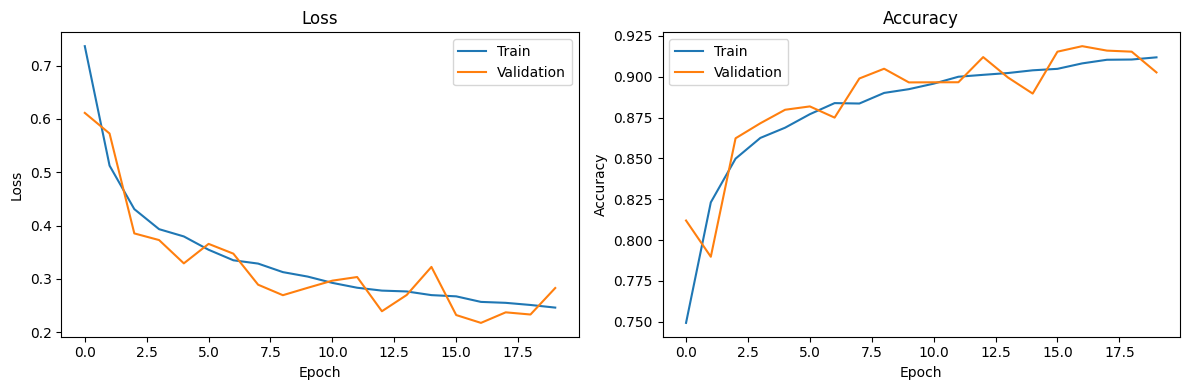

In [ ]:
# 학습 곡선 시각화
plt.figure(figsize=(12, 4))

# 손실(loss) 곡선
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도(accuracy) 곡선
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 테스트 데이터로 모델 평가. 손실과 정확도 출력
test_loss, test_acc = model.evaluate(test_fashion_images, test_fashion_labels)
print('테스트 loss:', test_loss, '테스트 정확도:', test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.4114 - accuracy: 0.8768
테스트 loss: 0.4114445447921753 테스트 정확도: 0.876800000667572


313/313 [==============================] - 1s 3ms/step


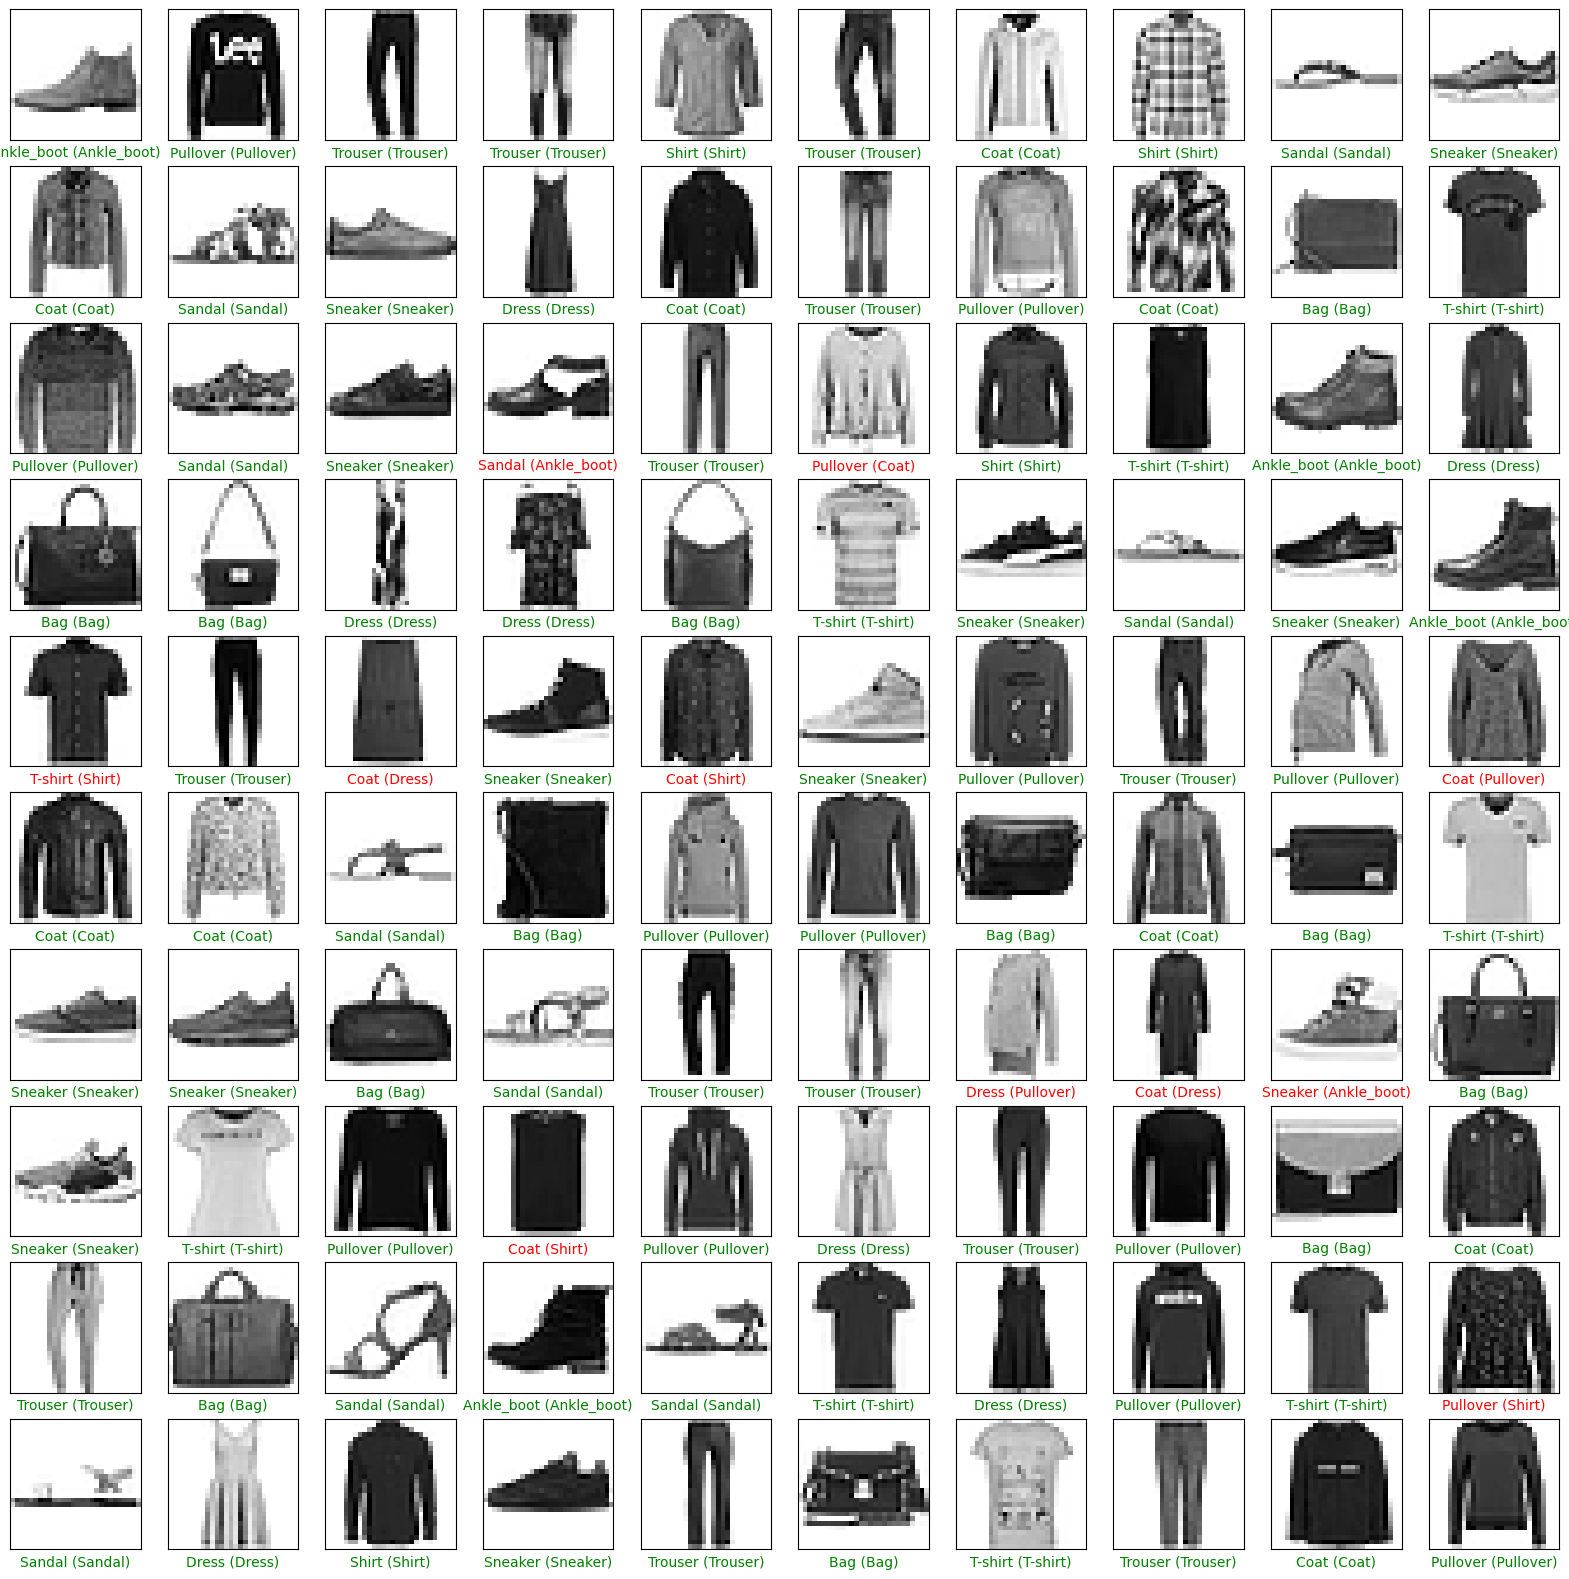

In [ ]:
# 위의 내용을 바탕으로 예측 결과 시각화
predictions = model.predict(test_fashion_images)
num_rows = 10
num_cols = 10
num_images = num_rows * num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(test_fashion_images[i], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    predicted_label = np.argmax(predictions[i])
    true_label = test_fashion_labels[i]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel("{} ({})".format(label_list[predicted_label], label_list[true_label]), color=color) #label을 텍스트로 바꿈
plt.show()

생각보다 정확도가 높지 않음.. epoch수를 늘리면 더 좋은 결과가 나오지 않을까? 내 컴퓨터가 논문의 epoch값을 못 버틸 것 같아서 시도하지 않았다. 이외에도 하이퍼파라미터 값 설정하는 부분에서 오류가 있을 수도 있다.